In [275]:
import sys
import numpy as np
import pandas as pd
import sympy
from copy import copy
from matplotlib import collections  as mc
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

import urllib.request
from scipy.spatial import KDTree

In [5]:
!mkdir TSPLIB_DATA

mkdir: TSPLIB_DATA: File exists


In [6]:
TSPLIB_DATA="./TSPLIB_DATA/"

# Download sample TSLIB instances

In [9]:
def download_tsplib_instance(instance_name="a280.tsp"):
    
    base_url = "https://raw.githubusercontent.com/yafeunteun/tsplib/master/"
    complete_url = base_url + instance_name
    output_filepath = TSPLIB_DATA + instance_name
    urllib.request.urlretrieve(complete_url, output_filepath)

In [10]:
download_tsplib_instance()

In [13]:
!ls TSPLIB_DATA
!head TSPLIB_DATA/a280.tsp

a280.tsp
NAME : a280
COMMENT : drilling problem (Ludwig)
TYPE : TSP
DIMENSION: 280
EDGE_WEIGHT_TYPE : EUC_2D
NODE_COORD_SECTION
  1 288 149
  2 288 129
  3 270 133
  4 256 141


# Read TSPLIB

In [54]:
def read_tsplib(filepath_to_tsplib_file):
    coordinates = [] 
    dim = 0
    start_read_coords = False
    with open(filepath_to_tsplib_file, "r") as f:
        line = f.readline().strip() or "EOF"
        while not line.startswith("EOF"):
            if start_read_coords:
                _id, x, y = (float(x) for x in line.split())
                coordinates.append((x,y))
            if line.startswith("DIMENSION"):
                dim = int(line.split(':')[1].strip())
            if line.startswith("NODE_COORD_SECTION"):
                start_read_coords = True
            line = f.readline().strip()
    assert len(coordinates) == dim, "Number of coordinates doesn't match the dimension parameter in file."
    
    return coordinates

In [55]:
coords = read_tsplib(TSPLIB_DATA + 'a280.tsp')

In [56]:
coords[:5]

[(288.0, 149.0),
 (288.0, 129.0),
 (270.0, 133.0),
 (256.0, 141.0),
 (256.0, 157.0)]

# KDTree

In [60]:
kdtree = KDTree(coords, leafsize=15)

In [62]:
cityID = 0
coords[cityID]

(288.0, 149.0)

In [70]:
distances, ids = kdtree.query(coords[cityID], 15)

In [71]:
ids

array([  0, 279,   1,   2,   3,   4, 278, 241, 242,   5, 276, 277, 240,
       247, 243])

# TSP utils

In [202]:
def score_tour(tour, cities=coords):
    df = pd.DataFrame()
    df['CityId'] = range(len(cities))
    df['X'] = np.array(coords)[:,0]
    df['Y'] = np.array(coords)[:,1]
    df = df.reindex(tour + [0]).reset_index()
    primes = list(sympy.primerange(0, len(cities)))
    df['prime'] = df.CityId.isin(primes).astype(int)
    df['dist'] = np.hypot(df.X - df.X.shift(-1), df.Y - df.Y.shift(-1))
    df['penalty'] = df['dist'][9::10] * (1 - df['prime'][9::10]) * 0.1
    return df.dist.sum() #+ df.penalty.sum()

In [136]:
def plot_path(path, coordinates, k=0):
    # Plot tour
    lines = []
    distances = [] 
    for i in range(1, len(path)):
        line = [coordinates[path[i-1]], coordinates[path[i]]]
        (x1, y1), (x2, y2) = line
        distance = np.sqrt((x1-x2)**2 + (y1-y2)**2)
        distances.append(distance)   
        if distance > k:
            lines.append(line)
        
    lc = mc.LineCollection(lines, linewidths=2)
    fig, ax = plt.subplots(figsize=(20,20))
    ax.set_aspect('equal')
    plt.grid(False)
    ax.add_collection(lc)
    ax.autoscale()
    #return distances

# Heuristics

## 2-OPT

In [203]:
route = list(range(len(coords))) + [0]

In [204]:
score_tour(route, coords)

2818.6216422394723

In [228]:
def two_opt(route):
    best = route
    improved = True
    while improved:
        improved = False
        for i in tqdm(range(1, len(route)-2)):
            for j in range(i+1, len(route)):
                if j-i == 1: continue # changes nothing, skip then                
                new_route = route[:]
                new_route[i:j] = route[j-1:i-1:-1] # this is the 2woptSwap
                if score_tour(new_route) < score_tour(best):
                    print(score_tour(best))
                    best = new_route
                    improved = True
        route = best
    return best

In [229]:
route = list(range(len(coords))) + [0]
route = two_opt(route)

  1%|          | 2/278 [00:06<15:46,  3.43s/it]

2818.6216422394723
2817.7864752705154


  4%|▎         | 10/278 [00:29<14:01,  3.14s/it]

KeyboardInterrupt: 

In [234]:
def two_opt_fast(route):
    best = route
    improved = True
    while improved:
        improved = False
        for i in range(1, len(route)-2):
            for j in kdtree.query(coords[route[i]], 15)[1][1:]:
                pos_j = route.index(j)
                if j == route[i+1]: break # changes nothing, skip then  
                if pos_j <= i: continue
                new_route = route[:]
                new_route[i:pos_j] = route[pos_j-1:i-1:-1] # this is the 2woptSwap
                if score_tour(new_route) < score_tour(best):
                    print(score_tour(best))
                    best = new_route
                    improved = True
        route = best
    return best

In [235]:
route = list(range(len(coords))) + [0]
route = two_opt_fast(route)

2818.6216422394723
2817.7864752705154
2814.167831161837
2813.33266419288
2811.2645464550797
2810.4293794861223
2807.3898431542034
2807.389843154203
2804.350306822284
2802.4753366429923


## 3-opt

In [237]:
def distance(a,b):
    Xa, Ya = coords[a]
    Xb, Yb = coords[b]
    
    return np.sqrt( (Xa-Xb)**2 + (Ya-Yb)**2 )

In [241]:
route

[0,
 1,
 278,
 277,
 276,
 275,
 274,
 273,
 272,
 271,
 270,
 269,
 268,
 267,
 266,
 265,
 264,
 263,
 262,
 261,
 260,
 259,
 258,
 257,
 256,
 255,
 254,
 253,
 252,
 251,
 250,
 249,
 248,
 247,
 246,
 245,
 244,
 243,
 242,
 241,
 240,
 239,
 238,
 237,
 236,
 235,
 234,
 233,
 232,
 231,
 230,
 229,
 228,
 227,
 226,
 225,
 224,
 223,
 222,
 221,
 220,
 219,
 218,
 217,
 216,
 215,
 214,
 213,
 212,
 211,
 210,
 209,
 208,
 207,
 206,
 205,
 204,
 203,
 202,
 201,
 200,
 199,
 198,
 197,
 196,
 195,
 194,
 193,
 192,
 191,
 190,
 189,
 188,
 187,
 186,
 185,
 184,
 183,
 182,
 181,
 180,
 179,
 178,
 177,
 176,
 175,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 159,
 158,
 157,
 156,
 153,
 154,
 152,
 155,
 151,
 150,
 149,
 148,
 147,
 146,
 145,
 144,
 143,
 142,
 141,
 140,
 139,
 138,
 137,
 136,
 135,
 134,
 133,
 132,
 131,
 130,
 129,
 128,
 127,
 126,
 125,
 124,
 123,
 122,
 121,
 120,
 119,
 118,
 117,
 116,
 115,
 114,
 1

In [259]:
def reverse_segment_if_better(tour, i, j, k):
    "If reversing tour[i:j] would make the tour shorter, then do it."
    # Given tour [...A-B...C-D...E-F...]
    A, B, C, D, E, F = tour[i-1], tour[i], tour[j-1], tour[j], tour[k-1], tour[k % len(tour)]
    d0 = distance(A,B) + distance(C,D) + distance(E,F)
    d1 = distance(A,C) + distance(B,D) + distance(E,F)
    d2 = distance(A,B) + distance(C,E) + distance(D,F)
    d3 = distance(A,D) + distance(E,B) + distance(C,F)
    d4 = distance(F,B) + distance(C,D) + distance(E,A)

    if d0 > d1:
        tour[i:j] = reversed(tour[i:j])
        return -d0 + d1
    elif d0 > d2:
        tour[j:k] = reversed(tour[j:k])
        return -d0 + d2
    elif d0 > d4:
        tour[i:k] = reversed(tour[i:k])
        return -d0 + d4
    elif d0 > d3:
        tmp = tour[j:k], tour[i:j]
        tour[i:k] = tmp
        return -d0 + d3
    return 0

In [262]:
def three_opt(tour):
    "Iterative improvement based on 3 exchange."
    while True:
        delta = 0
        for (a,b,c) in all_segments(len(tour)):
            delta += reverse_segment_if_better(tour, a, b, c)
        if delta >= 0:
            break
        print(score_tour(tour))
    return tour

def all_segments(N):
    "Generate all segments combinations"
    return ((i, j, k)
        for i in range(N)
        for j in range(i+2, N)
        for k in range(j+2, N+(i>0)))

In [267]:
_ = three_opt(route)

In [268]:
score_tour(route)

2768.53642130435

In [272]:
route = two_opt_fast(route)
score_tour(route)

2768.53642130435

In [ ]:
   
    d0 = score_tour(tour)
    d1 = distance(A,C) + distance(B,D) + distance(E,F)
    d2 = distance(A,B) + distance(C,E) + distance(D,F)
    d3 = distance(A,D) + distance(E,B) + distance(C,F)
    d4 = distance(F,B) + distance(C,D) + distance(E,A)

    new_route = route[:]
                new_route[i:pos_j] = route[pos_j-1:i-1:-1] # this is the 2woptSwap
                if score_tour(new_route) < score_tour(best):
                    print(score_tour(best))
                    best = new_route
                    improved = True
    
    
    if d0 > d1:
        tour[i:j] = reversed(tour[i:j])
        return -d0 + d1
    elif d0 > d2:
        tour[j:k] = reversed(tour[j:k])
        return -d0 + d2
    elif d0 > d4:
        tour[i:k] = reversed(tour[i:k])
        return -d0 + d4
    elif d0 > d3:
        tmp = tour[j:k], tour[i:j]
        tour[i:k] = tmp
        return -d0 + d3

In [363]:
def find_best_reconnection(tour, a1, a2, b1, b2, c1, c2):
    
    best_score = score_tour(tour)
    best_route = tour
    
    new_route1 = tour[:a2]
    new_route1.extend(reversed(tour[b2:c2]))
    new_route1.extend(tour[a2:b2])
    new_route1.extend(tour[c2:])
    new_score1 = score_tour(new_route1)
    if new_score1 < best_score:
        best_score = new_score1
        best_route = new_route1
    
    new_route2 = tour[:a2]
    new_route2.extend(reversed(tour[a2:b2]))
    new_route2.extend(reversed(tour[b2:c2]))
    new_route2.extend(tour[c2:])
    new_score2 = score_tour(new_route2)
    if new_score2 < best_score:
        best_score = new_score2
        best_route = new_route2
    
    
    new_route3 = tour[:a2]
    new_route3.extend(tour[b2:c2])
    new_route3.extend(reversed(tour[a2:b2]))
    new_route3.extend(tour[c2:])
    new_score3 = score_tour(new_route3)
    if new_score3 < best_score:
        best_score = new_score3
        best_route = new_route3
    
    new_route4 = tour[:a2]
    new_route4.extend(tour[b2:c2])
    new_route4.extend(tour[a2:b2])
    new_route4.extend(tour[c2:])
    new_score4 = score_tour(new_route4)
    if new_score4 < best_score:
        best_score = new_score4
        best_route = new_route4
     
    return best_route
    

In [330]:
find_best_reconnection([ "a1","a2","b1","b2","c1","c2", "a1" ], 0, 1, 2, 3, 4, 5)

['a1', 'a2', 'b1', 'b2', 'c1', 'c2', 'a1']

In [385]:
def three_opt_fast(route):
    best = route
    improved = True
    while improved:
        improved = False
        for i in range(1, len(route)-2):
            for j in kdtree.query(coords[route[i]], 15)[1][1:]:
                pos_j = route.index(j)
                if j == route[i+1]: break # changes nothing, skip then  
                if pos_j <= i: continue
                    
                for k in kdtree.query(coords[j], 15)[1][1:]:
                    pos_k = route.index(k)
                    if k == route[pos_j+1]: break # changes nothing, skip then  
                    if pos_k <= pos_j: continue
                    
                    new_route = find_best_reconnection(route, i, i+1, pos_j, pos_j+1, pos_k, pos_k+1)
                    #print(score_tour(new_route))
                    if score_tour(new_route) < score_tour(best):
                        print(score_tour(new_route))
                        best = new_route
                        improved = True
                         
        route = best
    return best

In [386]:
route = list(range(len(coords))) + [0]
route = two_opt_fast(route)

2818.6216422394723
2817.7864752705154
2814.167831161837
2813.33266419288
2811.2645464550797
2810.4293794861223
2807.3898431542034
2807.389843154203
2804.350306822284
2802.4753366429923


In [408]:
route = three_opt_fast(route)

In [418]:
score_tour(route)

2742.4251020992506

In [419]:
#route = double_bridge(route)
route = two_swap(route)

In [420]:
score_tour(route)

2825.0215446619445

In [421]:
route = two_opt_fast(route)

2825.0215446619445
2814.499477853801


In [422]:
route = three_opt_fast(route)

2734.0949645155442


In [435]:
ll = list(range(1,len(coords)))
np.random.shuffle(ll)

32951.669873931605
32938.881561562135
32932.41060072164
32894.5963771111
32879.54490558049
32854.329880920384
32838.902001364884
32830.47424695776
32823.373418164534


KeyboardInterrupt: 

In [438]:
route = [0] + ll + [0]
assert len(set(route)) == len(route)-1

In [439]:
route = two_opt_fast(route)
route = three_opt_fast(route)
route = two_swap(route)
route = two_opt_fast(route)
route = three_opt_fast(route)
delta = 100*(score_tour(route)-2579)/2579
delta

33184.230071842845
33157.32533041091
33056.74426269841
33027.202345838734
32987.04051623002
32935.30590954105
32892.46063809306
32849.62691561824
32774.972214352616
32729.46482623649
32688.54579477463
32552.57862240691
32549.161796480137
32522.795271573534
32491.36357949546
32485.068323066036
32484.720495065816
32480.465539325574
32420.11691810851
32403.066126517
32393.398926366404
32350.19181943432
32336.45804001869
32233.78054916827
32230.77056574705
32209.730272044246
32201.2335252622
32183.648719049135
32047.681546681415
32026.62099304502
32017.89819584804
31986.466503769967
31980.171247340542
31979.823419340322
31915.219842383016
31898.169050791505
31776.50655381435
31728.883473442776
31696.336449536706
31560.369277168986
31556.952451242214
31499.146893923884
31494.00167079851
31485.785210482496
31427.907572870587
31410.856781279075
31401.18958112848
31357.982474196397
31344.248694780767
31241.571203930347
31238.56122050913
31203.37090781106
31067.40373544334
31063.986909516567
31

16871.58409462125
16848.56599846109
16825.657049783607
16822.628597352683
16784.365212260996
16743.091866382812
16649.973350608838
16641.40969699331
16639.063179995926
16616.045083835772
16590.107682727357
16561.43556017291
16552.69850843302
16510.67818885498
16469.4048429768
16376.286327202826
16367.722673587297
16365.376156589915
16342.358060429757
16319.449111752276
16316.420659321346
16287.748536766896
16279.011485027004
16278.678188854981
16237.404842976799
16144.286327202826
16135.722673587296
16110.358060429757
16087.449111752274
16085.15304076526
16055.748536766896
16047.011485027004
16005.738139148822
15912.61962337485
15904.055969759318
15878.69135660178
15853.486336937283
15842.439108535887
15841.858274024355
15829.477639858756
15788.204293980574
15695.085778206601
15686.522124591069
15661.157511433534
15635.952491769034
15624.324428856107
15619.72243645153
15612.356719107236
15609.019384598152
15535.973757468868
15489.932567203952
15481.36891358842
15456.004300430883
15433.

6815.086253816253
6810.241843612541
6796.787465365507
6787.879249237665
6784.0059614715665
6782.464808851517
6781.600079436625
6768.0059614715665
6763.1615512678545
6749.70717302082
6740.798956892979
6736.572946884349
6701.494521363475
6699.953368743425
6699.088639328534
6685.4945213634755
6685.494521363475
6680.650111159764
6667.195732912729
6653.045448877402
6649.945495479498
6648.404342859449
6647.539613444556
6633.945495479498
6633.945495479497
6629.101085275785
6615.646707028751
6601.496422993425
6598.61158881972
6597.07043619967
6596.205706784778
6582.61158881972
6573.080887114993
6564.3128003689735
6555.404584241132
6554.616425805297
6553.006710952293
6551.465558332244
6550.6008289173515
6537.006710952293
6537.006710952292
6527.476009247566
6518.707922501546
6504.55763846622
6496.021865947352
6494.4807133273025
6493.61598391241
6480.021865947352
6480.021865947351
6470.491164242625
6461.723077496605
6452.8148613687645
6452.026702932929
6450.485550312879
6449.620820897987
6436.026

4001.2852976853537
3999.2099271863754
3998.660032201159
3998.546296150081
3997.5355076312003
3988.4408874816418
3986.3655169826634
3985.815621997447
3985.701885946369
3976.6072657968107
3974.5318952978323
3973.982000312617
3965.9247983063724
3956.830178156814
3954.754807657836
3954.2049126726197
3945.1102925230616
3943.0349220240832
3942.8912041736353
3940.5924157228883
3931.49779557333
3929.422425074352
3929.278707223904
3929.140911370532
3920.046291220974
3917.9709207219953
3917.8272028715473
3908.7325827219893
3906.6572122230104
3897.562592073452
3897.3306954230547
3893.619489558391
3893.261090905483
3890.76901902992
3874.6572122230104
3865.562592073452
3865.3306954230547
3861.619489558391
3861.261090905483
3858.76901902992
3849.674398880361
3849.4425022299642
3845.7312963653003
3845.372897712392
3836.278277562834
3836.0463809124367
3832.3351750477723
3832.1180637164534
3823.0234435668945
3822.7915469164973
3819.080341051834
3809.985720902275
3809.4678441021024
3800.3732239525434
37

19.16330338333449

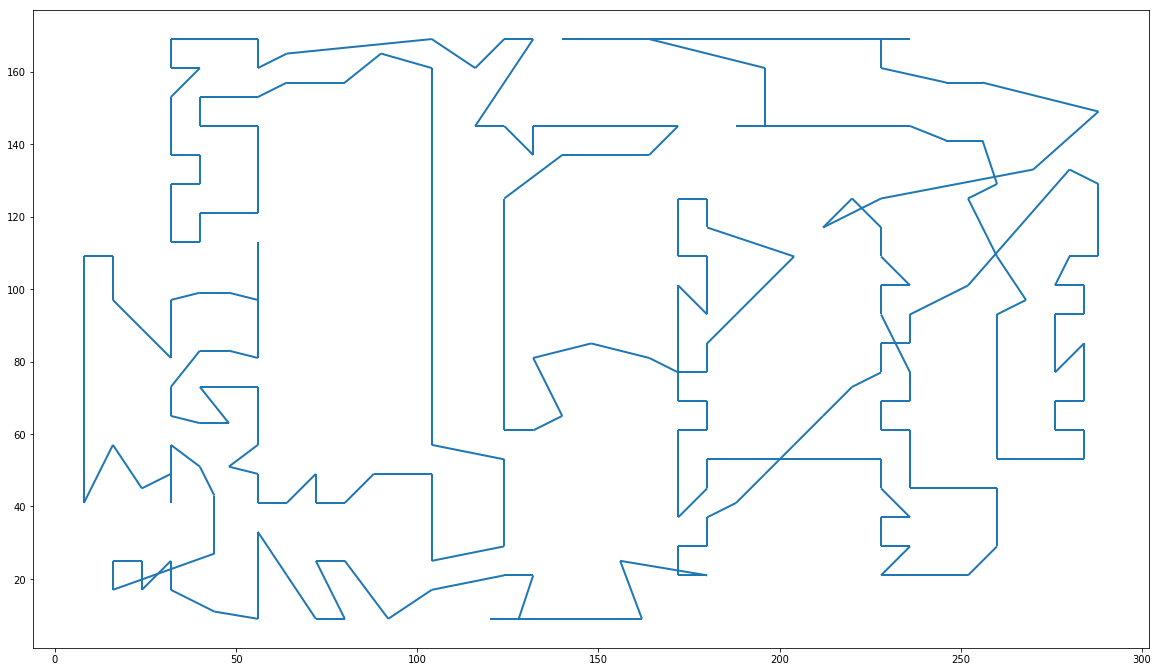

In [440]:
plot_path(route, coords)

In [446]:
def ILS(route, n_iter=100, optimum=None):
    route = two_opt_fast(route)
    route = three_opt_fast(route)
    best_score = score_tour(route)
    
    for i in range(n_iter):
        route = two_swap(route)
        route = two_opt_fast(route)
        route = three_opt_fast(route)
        score = score_tour(route)
        print("Iteration #{} => {}".format(i, score))
        if score < best_score:
            best_score = score
            if optimum:
                print("Delta: {}".format(100*(score_tour(route)-optimum)/optimum))
    return (route, best_score)

In [ ]:
best_route, best_score = ILS(route, optimum=2579)

3073.2215942561966
3053.2466152413663
3018.9609628211397
3018.57691944813
3004.708058886084
3004.3240155130743
3302.6741387832903
3292.785594963292
3285.213070720766
3267.7781796441777
3254.968989272965
3245.427086965444
3245.4270869654433
3213.7721943975134
3198.477713309031
3192.056431874806
3184.5000471260764
3178.579780097369
3175.456332995052
3175.4563329950515
3161.7420686133946
3145.8411256308164
3088.437875775477
3075.930864373299
3059.655183500425
3004.3240155130743
Iteration #0 => 3004.3240155130743
3090.6517472154546
3088.2295421135987
3069.285060460969
Iteration #1 => 3004.3240155130743
3338.5112631738702
3335.7050146990046
3332.0890580720143
3315.295353217375
3305.0468529475656
3298.272294391164
3298.1668477468947
3249.9221772462115
3041.4898144093186
3035.736025660554
3009.982236911789
3007.3916367332286
Iteration #2 => 3007.3916367332286
3124.560012332403
3121.852168833863
3112.9044012597287
3007.3916367332286
3004.683793234688
2995.7360256605534
Iteration #3 => 2993.028

# Perturbations 

In [417]:
def two_swap(route):
    
    i = np.random.randint(1, len(route)-3)
    
    j = np.random.randint(i+2, len(route)-1)
    
    new_route = route[:]
    new_route[i:j] = route[j-1:i-1:-1] 
    
    return new_route

In [388]:
def double_bridge(route):
#    i, ii, j, jj, k, kk, l, ll = 3, 4, 9, 10, 28, 29, 35, 36
    
    i = np.random.randint(1, len(route)-7)
    ii = i+1
    
    j = np.random.randint(i+2, len(route)-5)
    jj = j+1
    
    k = np.random.randint(j+2, len(route)-3)
    kk = k+1
    
    l = np.random.randint(k+2, len(route)-1)
    ll = l+1
    
    new_route = route[0:ii]

    new_route.append(route[kk])
    new_route.extend(route[kk+1:l+1])
    new_route.append(route[jj])
    new_route.extend(route[jj+1:k+1])
    new_route.append(route[ii])
    new_route.extend(route[ii+1:j+1])
    new_route.append(route[ll])
    new_route.extend(route[ll+1:])


    assert len(new_route)==len(route)
    assert new_route[0]==new_route[-1]==0
    assert len(set(new_route))==len(new_route)-1
    
    return new_route

[0,
 1,
 278,
 277,
 276,
 275,
 274,
 273,
 272,
 271,
 270,
 269,
 268,
 267,
 266,
 265,
 264,
 263,
 262,
 261,
 260,
 259,
 258,
 257,
 256,
 255,
 254,
 253,
 252,
 251,
 250,
 249,
 248,
 247,
 246,
 243,
 242,
 241,
 240,
 239,
 244,
 245,
 238,
 237,
 236,
 235,
 234,
 233,
 232,
 231,
 230,
 229,
 228,
 227,
 226,
 225,
 224,
 223,
 222,
 221,
 220,
 219,
 218,
 217,
 216,
 215,
 214,
 213,
 212,
 211,
 210,
 209,
 208,
 207,
 206,
 205,
 204,
 203,
 202,
 201,
 200,
 199,
 198,
 197,
 196,
 195,
 194,
 193,
 192,
 191,
 190,
 189,
 188,
 187,
 186,
 185,
 184,
 183,
 182,
 181,
 180,
 179,
 178,
 177,
 176,
 175,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 159,
 158,
 157,
 156,
 153,
 154,
 152,
 155,
 151,
 150,
 149,
 148,
 147,
 146,
 145,
 144,
 143,
 142,
 141,
 140,
 139,
 138,
 137,
 136,
 135,
 134,
 133,
 132,
 131,
 130,
 129,
 128,
 127,
 126,
 125,
 124,
 123,
 122,
 121,
 120,
 119,
 118,
 117,
 116,
 115,
 114,
 1